In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import random
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [9]:
movies['genres_split'] = movies['genres'].str.split('|')
genres_dummies = movies['genres_split'].explode().str.get_dummies().groupby(level=0).sum()
movies = movies[['movieId', 'title']].join(genres_dummies)

In [10]:
ratings.drop(columns=['timestamp'], inplace=True)
movies = movies.drop(columns=['(no genres listed)'])

In [11]:
movie_1 = movies

In [12]:
movie_v1 = movie_1.drop(columns=['title'])

In [13]:
movie_v1

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62419,209159,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
62420,209163,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
62421,209169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
data_all = movie_v1.merge(ratings, on='movieId')

In [15]:
import numpy as np

results = []

for _ in range(150):
    refresh = np.random.choice([True, False]) 
    if not refresh:
        choice = np.random.randint(10)
        rating = np.random.randint(1, 6)
    else:
        choice = 0 
        rating = 0

    results.append([refresh, choice, rating])

results_array = np.array(results)

### Deep Q-Learning

In [ ]:
class DQL_model:
    def __init__(self, state_size, action_size, 
            epsilon= 0.6,gamma= 0.75 , epsilon_decay=0.99, learning_rate=0.01, batch_size=32, tau=0.05):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.gamma = gamma
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.tau = tau
        self.user_satisfaction, self.stability = 0, 0
        
        self.memory = deque(maxlen=2000)
                
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_dim= self.state_size, activation= 'relu'))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(32, activation= 'relu'))
        model.add(keras.layers.Dense(self.action_size))
        
        model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate= self.learning_rate))
        
        return model
    
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size, size=5, replace=False)
        
        state = state.astype(np.float32)
        act_values = self.model.predict(np.reshape(state, [1,self.state_size]))
        
        top_5_indices = np.argsort(act_values[0])[-5:][::-1]
        
        print(f"top 5 indices: {top_5_indices}")
        return top_5_indices
    
    def update_target_model(self):
        model_w =  self.model.get_weights()
        target_model_w = self.target_model.get_weights()
        
        target_model_w = [self.tau * model_w[i] + (1 - self.tau) * target_model_w[i] for i in range(len(target_model_w))]  
        
        self.target_model.set_weights(target_model_w)
    
    def adjust_parameters(self):
        if self.user_satisfaction < 3:
            self.epsilon = min(0.9, self.epsilon + 0.05)
        if self.user_satisfaction > 3:
            self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)
            
        if self.stability < 0.4:
            self.gamma = max(0.9, self.gamma * 1.05)
        if self.stability > 1:
            self.gamma = min(0.5, self.gamma - 0.05)

    def train(self):
        if len(self.memory) < self.batch_size:
            return
                
        minibatch = random.sample(self.memory, self.batch_size)
                
        for state, action, reward, next_state in minibatch:

            current_q_values = self.model.predict(np.reshape(state, [1, self.state_size]))

            next_q_values = self.target_model.predict(np.reshape(next_state, [1, self.state_size]))

            # Bellman
            target_q_value = reward + self.gamma * np.amax(next_q_values[0])

            target_f = current_q_values.copy()
            target_f[0][action] = target_q_value
            
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)      
        
        self.update_target_model()
                    
        self.adjust_parameters()

In [43]:

class Env:
    def __init__(self,data_movie, data, user_id, model):
        # load data users and movies
        self.data = data
        self.user_id = user_id
        self.data_movie = data_movie
        self.dqn_model = model  # dqn model
        
        # get user
        self.user_data = self.data[self.data['userId'] == self.user_id]
        self.user_data.drop(columns=['userId'], inplace=True)
        
        # get genres
        self.genres = self.user_data.columns[1:-1]
        self.user_data.drop(columns=['movieId'], inplace=True)
        
        # storage data
        self.storage = self.user_data[self.genres]
        self.memory = None
        self.movie_suggestions = None
                
        # rating movie
        self.refresh_count = 0
        self.max_refresh = 10
        
        self.total_reward = [0]
        self.list_user_satisfaction = []
        
        self.get_memory_from_user_data() 
        
        self.dqn_model.user_satisfaction, self.dqn_model.stability = self.calc_user_statisfaction()    
         
        self.reset()
        
    def reset(self): 
        self.movie_suggestions = self.data_movie.sample(10)
        self.refresh_count = 0
        print('Reset')
        return self.movie_suggestions
    
    def suggest_next_movie(self):
        if self.refresh_count == self.max_refresh or self.memory is None:
            self.reset()
        else:    
            self.movie_suggestions = None
            
            current_state = self.memory[self.genres].values.astype(np.float32)
                
            suggested_genres_indices = self.dqn_model.act(current_state)
                            
            for genre_index in suggested_genres_indices:
                filtered_movie = self.data_movie[self.data_movie[self.genres[genre_index]] == 1]
                
                if not filtered_movie.empty:
                    print(f"genre: {self.genres[genre_index]}")
                    self.movie_suggestions = pd.concat([self.movie_suggestions, filtered_movie.sample(1)])
                else:
                    self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(1)])
            
            self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(5)])
            
            return self.movie_suggestions
        
    
    def storage_data(self):
        if self.memory is not None:
            new_row = pd.DataFrame([self.memory[self.genres].values], columns=self.genres)
            self.storage = pd.concat([self.storage, new_row], ignore_index=True)
        return self.storage
    
    def reward_movie(self, rating):
        reward = rating
        
        # refresh
        penalty_refresh =  self.refresh_count * 0.04
        reward -= penalty_refresh        

        # user satisfaction
        if self.dqn_model.user_satisfaction >= 4:
            reward += rating * 0.03
        elif self.dqn_model.user_satisfaction < 2:
            reward -= rating * 0.08
        
        reward = np.clip(reward, 0, 5)
        
        self.dqn_model.user_satisfaction, self.dqn_model.stability = self.calc_user_statisfaction()
        
        print(f"user satisfaction: {self.dqn_model.user_satisfaction}")
        print(f"stability: {self.dqn_model.stability}")
        
            
        return reward 
    
    def rating_movie(self, rating= None):
        if rating is not None and self.memory is not None:
            
            self.memory = self.memory[self.genres]
            
            state = self.memory.values.astype(np.float32)
            
            action = self.dqn_model.act(state)
            
            reward = self.reward_movie(rating)
            
            self.total_reward.append(reward + self.total_reward[-1])
            
            next_state = state
            
            self.dqn_model.remember(state, action, reward, next_state)
            self.dqn_model.train()
            
            self.refresh_count = 0
            
            return self.memory
    
    def step(self, index = None, refresh= False):
        
        if refresh:
            self.refresh_count += 1
            if self.refresh_count == self.max_refresh:
                self.reset()   
                     
        if index is not None:
                                    
            self.selected_movie = self.movie_suggestions.iloc[index]
            
            self.memory = self.selected_movie
            
            return self.selected_movie
        
    def get_memory_from_user_data(self):
        for index, row in enumerate(self.user_data.itertuples()):
            state = self.user_data.iloc[index][self.genres].values
            
            action = [index for index, value in enumerate(state) if value == 1]
            
            if action:
                action = random.choice(action)
                            
            rating = row.rating
            
            reward = self.reward_movie(rating)
            
            self.total_reward.append(reward + self.total_reward[-1])
            
            if index + 1 < len(self.user_data):
                next_state = self.user_data.iloc[index + 1][self.genres].values
            else:
                next_state = self.user_data.iloc[index][self.genres].values
            
            self.dqn_model.remember(state, action, reward, next_state)
            
        self.dqn_model.train()
    
    def calc_user_statisfaction(self):
        list_rewards = [self.total_reward[i] - self.total_reward[i-1] for i in range(1, len(self.total_reward))]
        
        user_satisfaction = np.mean(list_rewards)
        stability = np.std(list_rewards)
                
        self.list_user_satisfaction.append(user_satisfaction)

        return user_satisfaction, stability

In [44]:
state_size=19
action_size=19

dql = DQL_model(state_size, action_size)
env = Env(movies,data_all, user_id= -1, model= dql)

for _ in range(150):
    # refresh = np.random.choice([True, False])
    refresh = results_array[_][0]
    if refresh:
        print(f"{_}: refresh")
    choice = None
    
    if not refresh:
        # choice = np.random.randint(10)
        choice = results_array[_][1]
        
    env.step(choice, refresh= refresh)
    
    if not refresh:
        # rating = np.random.randint(1,6)
        
        rating = results_array[_][2]
            
        env.rating_movie(rating= rating)
        
        print(f"{_}: choice moive:{choice}, rating:{rating}")
    
    env.suggest_next_movie()

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_832\3398719421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.user_data.drop(columns=['userId'], inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_832\3398719421.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Reset
0: refresh
Reset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
top 5 indices: [14  8  1 18  0]
user satisfaction: nan
stability: nan
1: choice moive:9, rating:5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
top 5 indices: [14  8  1 18  0]
genre: Romance
genre: Fantasy
genre: Adventure
genre: Western
genre: Action
2: refresh
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
top 5 indices: [14  8  1 18  0]
genre: Romance
genre: Fantasy
genre: Adventure
genre: Western
genre: Action
user satisfaction: 5.0
stability: 0.0
3: choice moive:3, rating:4
genre: IMAX
genre: Children
genre: Animation
genre: Sci-Fi
genre: Horror
user satisfaction: 4.48
stability: 0.5199999999999996
4: choice moive:8, rating:5
genre: Children
genre: Fantasy
genre: Horror
genre: Western
genre: Animation
5: refresh
genre: Drama
genre: Comedy
genre: Film-Noir
genre: War
genre: Western
user satisfaction: 4.653333333333333
stability: 0.49026070162267255
6: choice moive:9, rating:3
genre: Documentary
genre: Mystery
genre: Musical
genre: Horror


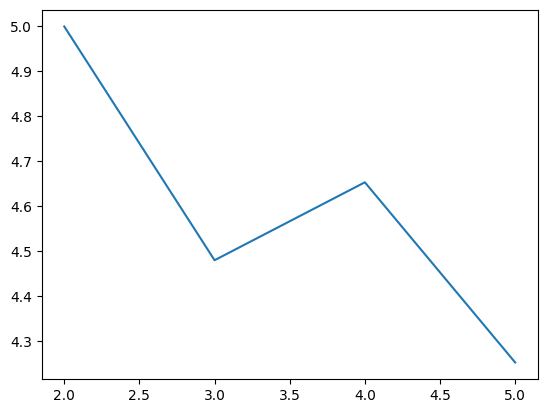

In [19]:
plt.plot( range(len(env.list_user_satisfaction)), env.list_user_satisfaction)
plt.show()

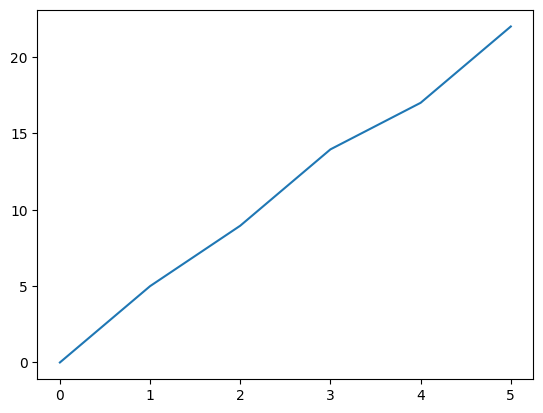

In [20]:
plt.plot(range(len(env.total_reward)), env.total_reward)

In [21]:
len(dql.memory)

5

In [22]:
len(env.total_reward)

6

In [23]:
env.calc_user_statisfaction()

(np.float64(4.402), np.float64(0.7869027894219206))

## REINFORCE - Policy Gradient Theorem

In [30]:
class REINFORCE:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        self.model = self._build_model()
        
        self.states = []
        self.actions = []
        self.rewards = []
        
    def _build_model(self):
        model = keras.Sequential([
            keras.layers.Dense(128, input_dim=self.state_size, activation='relu'),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(self.action_size, activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy')
        return model
    
    def act(self, state):
        state = state.reshape(1, -1)
        probabilities = self.model.predict(state, verbose=0)[0]
        actions = np.random.choice(self.action_size, 5, p=probabilities, replace=False)
        print(f"top 5 indices: {actions}")
        return actions
    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
    
    def update_policy(self):
        if not self.states:
            return
        
        discounted_rewards = self._discount_rewards(self.rewards)
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= (np.std(discounted_rewards) + 1e-7)

        actions_one_hot = np.zeros((len(self.actions), self.action_size))
        for idx, action in enumerate(self.actions):
            actions_one_hot[idx, action] = 1
        
        with tf.GradientTape() as tape:
            logits = self.model(np.array(self.states), training=True)
            log_prob = tf.math.log(tf.reduce_sum(logits * actions_one_hot, axis=-1))
            
            loss = -tf.reduce_mean(log_prob * discounted_rewards)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    
    def _discount_rewards(self, rewards, gamma=0.99):
        # G_t = R_t + γR_{t+1} + γ^2R_{t+2} + ...
        G = np.zeros_like(rewards, dtype=np.float32)
        cumulative_sum = 0
        for t in reversed(range(len(rewards))):
            cumulative_sum = cumulative_sum * gamma + rewards[t]
            G[t] = cumulative_sum
        return G

In [31]:
class Env:
    def __init__(self,data_movie, data, user_id, model):
        # load data users and movies
        self.data = data
        self.user_id = user_id
        self.data_movie = data_movie
        self.REINFORCE = model   # REINFORCE
        
        # get user
        self.user_data = self.data[self.data['userId'] == self.user_id]
        self.user_data.drop(columns=['userId'], inplace=True)
        
        # get genres
        self.genres = self.user_data.columns[1:-1]
        self.user_data.drop(columns=['movieId'], inplace=True)
        
        # storage data
        self.storage = self.user_data[self.genres]
        self.memory = None
        self.movie_suggestions = None
                
        # rating movie
        self.refresh_count = 0
        self.max_refresh = 10
        
        self.total_reward = [0]
        self.list_user_satisfaction = []
        
        self.user_satisfaction =0
        self.stability = 0
        
        self.get_memory_from_user_data()   
        
        self.user_satisfaction, self.stability = self.calc_user_statisfaction()
         
        self.reset()
        
    def reset(self): 
        self.movie_suggestions = self.data_movie.sample(10)
        self.refresh_count = 0
        print('Reset')
        return self.movie_suggestions
    
    def suggest_next_movie(self):
        if self.refresh_count == self.max_refresh or self.memory is None:
            self.reset()
        else:    
            self.movie_suggestions = None
            
            current_state = self.memory[self.genres].values.astype(np.float32)
                
            suggested_genres_indices = self.REINFORCE.act(current_state)
            
            for genre_index in suggested_genres_indices:
                filtered_movie = self.data_movie[self.data_movie[self.genres[genre_index]] == 1]
                
                if not filtered_movie.empty:
                    print(f"genre: {self.genres[genre_index]}")
                    self.movie_suggestions = pd.concat([self.movie_suggestions, filtered_movie.sample(1)])
                else:
                    print("random")
                    self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(1)])
            
            self.movie_suggestions = pd.concat([self.movie_suggestions, self.data_movie.sample(5)])
            
            return self.movie_suggestions
        
    
    def storage_data(self):
        if self.memory is not None:
            new_row = pd.DataFrame([self.memory[self.genres].values], columns=self.genres)
            self.storage = pd.concat([self.storage, new_row], ignore_index=True)
        return self.storage
    
    def reward_movie(self, rating):
        reward = rating
        
        # refresh
        penalty_refresh =  self.refresh_count * 0.04
        reward -= penalty_refresh        

        # user satisfaction
        if self.user_satisfaction >= 4:
            reward += rating * 0.03
        elif self.user_satisfaction < 2:
            reward -= rating * 0.08
        
        reward = np.clip(reward, 0, 5)
        
        self.user_satisfaction, self.stability = self.calc_user_statisfaction()
        
        print(f"user satisfaction: {self.user_satisfaction}")
        print(f"stability: {self.stability}")  
                  
        return reward 
    
    def rating_movie(self, rating= None):
        if rating is not None and self.memory is not None:
            
            self.memory = self.memory[self.genres]
            
            state = self.memory.values.astype(np.float32)
            
            action = self.REINFORCE.act(state)
            
            reward = self.reward_movie(rating)
            
            self.total_reward.append(reward + self.total_reward[-1])
                        
            self.REINFORCE.remember(state, action, reward)
            self.REINFORCE.update_policy()
            
            self.refresh_count = 0
            
            return self.memory
    
    def step(self, index = None, refresh= False):
        
        if refresh:
            self.refresh_count += 1
            if self.refresh_count == self.max_refresh:
                self.reset()   
                     
        if index is not None:
                                    
            self.selected_movie = self.movie_suggestions.iloc[index]
            
            self.memory = self.selected_movie
            
            return self.selected_movie
        
    def get_memory_from_user_data(self):
        if not self.user_data.empty:
            for index, row in enumerate(self.user_data.itertuples()):
                state = self.user_data.iloc[index][self.genres].values
                
                action = [index for index, value in enumerate(state) if value == 1]
                
                if action:
                    action = random.choice(action)
                
                rating = row.rating
                
                reward = self.reward_movie(rating)
                
                self.total_reward.append(reward + self.total_reward[-1])       
                
                self.REINFORCE.remember(state, action, reward)
                
            self.REINFORCE.update_policy()
    
    def calc_user_statisfaction(self):
        list_rewards = [self.total_reward[i] - self.total_reward[i-1] for i in range(1, len(self.total_reward))]
        
        user_satisfaction = np.mean(list_rewards)
        stability = np.std(list_rewards)
                
        self.list_user_satisfaction.append(user_satisfaction)

        return user_satisfaction, stability

In [32]:
state_size = 19 
action_size = 19 
reinforce = REINFORCE(state_size=state_size, action_size=action_size)
env = Env(movies,data_all, user_id= -1, model= reinforce)

for _ in range(150):
    # refresh = np.random.choice([True, False])
    refresh = results_array[_][0]
    if refresh:
        print(f"{_}: refresh")
    choice = None
    
    if not refresh:
        # choice = np.random.randint(10)
        choice = results_array[_][1]
        
    env.step(choice, refresh= refresh)
    
    if not refresh:
        # rating = np.random.randint(1,6)
        
        rating = results_array[_][2]
            
        env.rating_movie(rating= rating)
        
        print(f"{_}: choice moive:{choice}, rating:{rating}")
    
    env.suggest_next_movie()


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DELL\AppData\Local\Temp\ipykernel_832\2521382522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.user_data.drop(columns=['userId'], inplace=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_832\2521382522.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Reset
0: refresh
Reset
top 5 indices: [7 2 0 1 8]
user satisfaction: nan
stability: nan
1: choice moive:9, rating:5
top 5 indices: [18 16 15 14 17]
genre: Western
genre: Thriller
genre: Sci-Fi
genre: Romance
genre: War
2: refresh
top 5 indices: [ 3  4 11 16  0]
genre: Children
genre: Comedy
genre: IMAX
genre: Thriller
genre: Action
top 5 indices: [ 8  7  5 14  9]
user satisfaction: 5.0
stability: 0.0
3: choice moive:3, rating:4
top 5 indices: [12 16  1  7  4]
genre: Musical
genre: Thriller
genre: Adventure
genre: Drama
genre: Comedy
top 5 indices: [10 18  5  8 14]
user satisfaction: 4.48
stability: 0.5199999999999996
4: choice moive:8, rating:5
top 5 indices: [12  5 16 10  7]
genre: Musical
genre: Crime
genre: Thriller
genre: Horror
genre: Drama
5: refresh
top 5 indices: [13 11 17  2 14]
genre: Mystery
genre: IMAX
genre: War
genre: Animation
genre: Romance
top 5 indices: [11 17  2 14  7]
user satisfaction: 4.653333333333333
stability: 0.49026070162267255
6: choice moive:9, rating:3
top

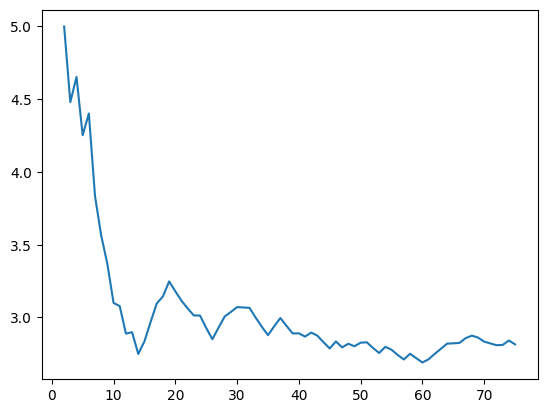

In [33]:
plt.plot( range(len(env.list_user_satisfaction)), env.list_user_satisfaction)

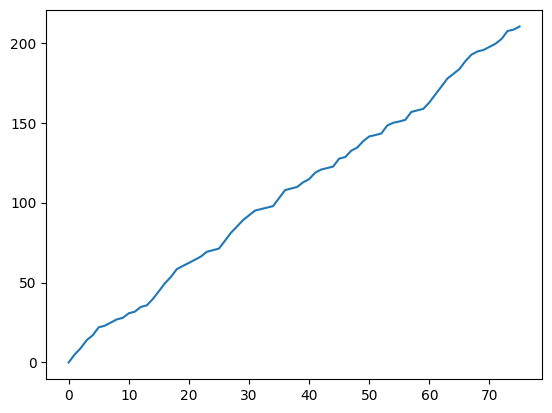

In [34]:
plt.plot(range(len(env.total_reward)), env.total_reward)